In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings

# Configure warnings
warnings.filterwarnings("ignore")

# Read data
df = pd.read_csv(r"data\Churn data.csv")

# Normalize stability and volume percentiles for each of the six consecutive months separately
def normalize_columns(df, columns):
    df_normalized = df.copy()
    scaler = MinMaxScaler()
    df_normalized[columns] = scaler.fit_transform(df[columns])
    return df_normalized

# Define stability and volume columns
stability_columns = [f'Stability_Month_{i}_Percentile' for i in range(1, 7)]
volume_columns = [f'Volume_Month_{i}_Percentile' for i in range(1, 7)]

# Normalize the columns
df_normalized = df.copy()
df_normalized[stability_columns] = normalize_columns(df, stability_columns)[stability_columns]
df_normalized[volume_columns] = normalize_columns(df, volume_columns)[volume_columns]
df_normalized.head()

,Customer_ID,Stability_Month_1_Percentile,Volume_Month_1_Percentile,Stability_Month_2_Percentile,Volume_Month_2_Percentile,Stability_Month_3_Percentile,Volume_Month_3_Percentile,Stability_Month_4_Percentile,Volume_Month_4_Percentile,Stability_Month_5_Percentile,Volume_Month_5_Percentile,Stability_Month_6_Percentile,Volume_Month_6_Percentile,Churn
0,Person_1,0.47,0.54,0.50,0.51,0.51,0.55,0.49,0.51,0.49,0.53,0.51,0.53,0
1,Person_2,0.54,0.55,0.53,0.64,0.54,0.73,0.53,0.82,0.56,0.91,0.55,1.00,0
2,Person_3,0.41,0.44,0.42,0.38,0.40,0.32,0.40,0.26,0.40,0.20,0.38,0.14,1
3,Person_4,0.43,0.66,0.39,0.59,0.42,0.52,0.43,0.45,0.40,0.38,0.40,0.31,1
4,Person_5,0.42,0.45,0.45,0.54,0.42,0.63,0.43,0.72,0.43,0.81,0.41,0.90,1


In [2]:
# Extract customer IDs
customer_ids = df['Customer_ID']

# Split the data into training and testing sets
X = df_normalized[stability_columns+volume_columns]
y = df_normalized['Churn']
X_train, X_test, y_train, y_test, customer_ids_train, customer_ids_test = train_test_split(X, y, customer_ids, test_size=0.2, random_state=42)

# Combine training features and labels
train_data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
majority_class = train_data[train_data['Churn'] == 0]
minority_class = train_data[train_data['Churn'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),    # to match majority class
                              random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
upsampled_train_data = pd.concat([majority_class, minority_upsampled])

# Separate features and labels
X_train_upsampled = upsampled_train_data.drop('Churn', axis=1)
y_train_upsampled = upsampled_train_data['Churn']

In [3]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

# Initialize the KFold object for cross-validation
n_splits = 5  # You can adjust the number of splits
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=11)

# Initialize the Random Forest classifier
model = RandomForestClassifier(random_state=13)

# Initialize Grid Search
classifier = GridSearchCV(model, param_grid, cv=kfold, scoring='f1', n_jobs=-1)

# Fit Grid Search to the data
classifier.fit(X_train_upsampled, y_train_upsampled)

# Best parameters from Grid Search
best_params = classifier.best_params_
print(f"Best parameters: {best_params}")

# Train the best model found by Grid Search
best_clf = classifier.best_estimator_

# Predict on the training set
y_train_pred = best_clf.predict(X_train_upsampled)

# Predict on the test set
y_test_pred = best_clf.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train_upsampled, y_train_pred)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


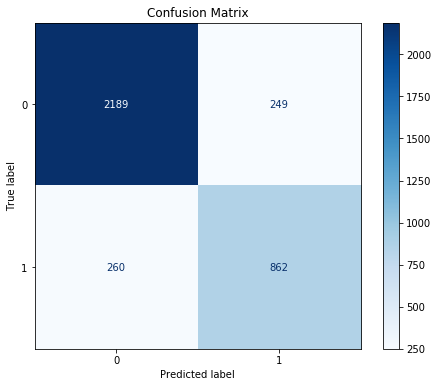

Classification Report:
               precision    recall  f1-score   support

   Not Churn       0.89      0.90      0.90      2438
       Churn       0.78      0.77      0.77      1122

    accuracy                           0.86      3560
   macro avg       0.83      0.83      0.83      3560
weighted avg       0.86      0.86      0.86      3560

F1 Score: 0.77
Test Accuracy: 0.86


In [4]:
# Display the confusion matrix with whole integers
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
classification_rep = classification_report(y_test, y_test_pred, target_names=['Not Churn', 'Churn'])
print("Classification Report:\n", classification_rep)
# Print the F1 score, test accuracy, train accuracy, and cross-validation scores
print(f'F1 Score: {f1:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

In [5]:
# Predict probabilities on the test set
y_test_prob = best_clf.predict_proba(X_test)[:, 1]
# Create a dataframe with the probabilities of churn
prob_df = pd.DataFrame({'Customer_ID': customer_ids_test, 'Actual': y_test, 'Predicted_Prob_Churn': y_test_prob}).reset_index(drop=True)
prob_df.tail()

,Customer_ID,Actual,Predicted_Prob_Churn
3555,Person_10956,0,0.126668
3556,Person_3300,0,0.194781
3557,Person_8970,0,0.168975
3558,Person_10597,1,0.817033
3559,Person_11231,0,0.351702
